# Hotdog classification: Test data

Для обучения было представлено три подхода:

* [Machine Learning](hotdog_ml.ipynb) с использованием `SGD` классификатора
* [Deel Learning](hotdog_dl.ipynb) с предобученными на `imagenet` сверточными сетями
* [VGG + SVM](hotdog_vgg_svm.ipynb) с использованием `FC` выхода из `VGG` как входных данных для `SVM`

Из представленных методов лучшим оказался Deep Learning (`densenet161`), что в целом не удивительно для данной задачи

Однако, подход `VGG` + `SVM` добился очень хороших результатов

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.autograd import Variable
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import copy

### Load trained `densenet161`

In [5]:
trained_densenet161 = models.densenet161(num_classes=2)
trained_densenet161.load_state_dict(torch.load('trained_densenet161.pth'))

C:\Users\Professional\Anaconda3\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [6]:
trained_densenet161

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inpla

### Load data

In [18]:
# Data augmentation and normalization for training
# Just normalization for validation
# Test same as validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
data_parts = [
    'train',
    'val',
    'test'
]

In [31]:
import sys
if sys.platform == 'win32':
    data_dir = os.path.abspath('_data\hotdogs_dataset')
else:
    data_dir = os.path.join(os.environ['HOME'], 'hse/data/hotdogs_dataset')
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in data_parts}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=False, num_workers=4)
              for x in data_parts}
dataset_sizes = {x: len(image_datasets[x]) for x in data_parts}
class_names = image_datasets['train'].classes
print(class_names)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

['hotdog', 'not_hotdog']


In [28]:
image_datasets['test'].classes

['unlabeled']

In [30]:
img_names = []
for f in os.listdir(os.path.join(data_dir, 'test/unlabeled')):
    img_names.append(f)

## Classification

In [52]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [65]:
def classify(model, dataloader, show=6):
    model = model.to(device)
    model.eval()  # handle dropout and batch-norm for test data
    labels = []
    images_so_far = 0
    fig = plt.figure()
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for i in range(inputs.size()[0]):
                label = 1 - preds.cpu().data.numpy()[i]  # inverse to make 0 == not_hotdog, 1 == hotdog
                if images_so_far < show:
                    images_so_far += 1
                    ax = plt.subplot(show//2, 2, images_so_far)
                    ax.axis('off')
                    ax.set_title('predicted: {}, {}'.format(label, class_names[preds[i]]))
                    imshow(inputs.cpu().data[i])
                labels.append(label)
    return labels

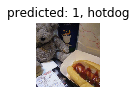

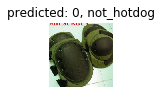

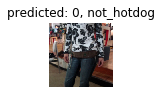

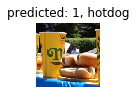

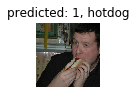

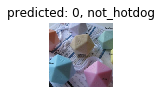

In [66]:
labels = classify(trained_densenet161, dataloaders['test'], show=6)

In [78]:
len(img_names) == len(labels)

True

### Assembling results

In [82]:
import pandas as pd
test_df = pd.DataFrame(list(zip(img_names, labels)), columns=['name', 'label'])

In [83]:
test_df.head()

,name,label
0,00000.jpg,1
1,00001.jpg,0
2,00002.jpg,0
3,00003.jpg,1
4,00004.jpg,1


In [88]:
if sys.platform == 'win32':
    sep = ';'
else:
    sep = ','
test_df.to_csv('test_labels.csv', sep=sep)